In [1]:
import torch
import torch.nn as nn
import torchvision
import pandas as pd
import numpy as np
import zipfile
import io
import pandas as pd
import math
from IPython.display import display
from collections import defaultdict

zipped_data_path = "../data/clean_data/class-competition-not-one-hot-encoders.zip"

dataframes = defaultdict(pd.DataFrame)
with zipfile.ZipFile(zipped_data_path, "r") as zip:
    for filename in zip.namelist():
        if filename.endswith(".csv"):
            with zip.open(filename) as f:
                dataframes.update({ filename : pd.read_csv(io.TextIOWrapper(f)) })

                # Lets take a look at the files
                print(f"FILE: {filename}")
                # If you want to see file info uncomment this:
                # display(dataframes[filename].info())
                # display(dataframes[filename].head())

train_data = dataframes["train.csv"]
test_data  = dataframes["test_public.csv"]

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

FILE: train.csv
FILE: test_public.csv
cuda:0


In [76]:
from sklearn.model_selection import train_test_split

ALL_FEATURES = ['TRIP_ID', 'ORIGIN_CALL', 'ORIGIN_STAND', 'TAXI_ID', 'MISSING_DATA',
 'POLYLINE', 'CALL_TYPE_A', 'CALL_TYPE_B', 'CALL_TYPE_C', 'YEAR_2013', 'YEAR_2014',
 'MONTH_1', 'MONTH_2', 'MONTH_3', 'MONTH_4', 'MONTH_5', 'MONTH_6',
 'MONTH_7', 'MONTH_8', 'MONTH_9', 'MONTH_10', 'MONTH_11', 'MONTH_12',
 'DAY_OF_WEEK_0', 'DAY_OF_WEEK_1', 'DAY_OF_WEEK_2', 'DAY_OF_WEEK_3',
 'DAY_OF_WEEK_4', 'DAY_OF_WEEK_5', 'DAY_OF_WEEK_6', 'HOUR_0', 'HOUR_1',
 'HOUR_2', 'HOUR_3', 'HOUR_4', 'HOUR_5', 'HOUR_6', 'HOUR_7', 'HOUR_8',
 'HOUR_9', 'HOUR_10', 'HOUR_11', 'HOUR_12', 'HOUR_13', 'HOUR_14',
 'HOUR_15', 'HOUR_16', 'HOUR_17', 'HOUR_18', 'HOUR_19', 'HOUR_20',
 'HOUR_21', 'HOUR_22', 'HOUR_23']

# We could totally change this. Utilization of these just probably requires further preprocessing.
ALL_FEATURES_NOT_SUITED_FOR_ESTIMATION = ['TRIP_ID', 'ORIGIN_CALL', 'ORIGIN_STAND', 'TAXI_ID', 'POLYLINE']

train_data_sample = train_data.sample(frac=0.5, random_state=420) # frac is used to control percentage of train data used
X = train_data_sample.drop("TRAVEL_TIME", axis=1)
X = X.loc[:, ~X.columns.isin(ALL_FEATURES_NOT_SUITED_FOR_ESTIMATION)]
y = train_data_sample["TRAVEL_TIME"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=420)

test_features = test_data.loc[:, ~test_data.columns.isin(ALL_FEATURES_NOT_SUITED_FOR_ESTIMATION)]

In [77]:
from torch.utils.data import DataLoader, Dataset
from cnn_utils import TaxiDataset
    
X_train = X_train.astype(float)
X_test = X_test.astype(float)
X_test_public = test_features.astype(float) # This is what we can predict on

X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.tolist(), dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.tolist(), dtype=torch.float32)
X_test_public_tensor = torch.tensor(X_test_public.values, dtype=torch.float32)

train_dataset = TaxiDataset(X_train_tensor, y_train_tensor)
test_dataset = TaxiDataset(X_test_tensor, y_test_tensor)
test_public_dataset = TaxiDataset(X_test_public_tensor)

batch_size = 32

dataloader_train = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
dataloader_test = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
dataloader_pred = DataLoader(test_public_dataset, batch_size=batch_size)

In [78]:
class CNN(nn.Module):
    '''
    Multilayer Perceptron for regression.
    '''
    def __init__(self):
        super(CNN, self).__init__()

        # Convolutional layers
        self.conv_layers = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.Sigmoid(),
            nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.Sigmoid(),
            nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.Sigmoid(),
            nn.Conv1d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.Sigmoid(),
        )

        # Fully connected layers
        self.fc_layers = nn.Sequential(
            nn.Linear(2560, 128),
            nn.Sigmoid(),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        x = x.unsqueeze(1)
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = self.fc_layers(x)
        return x

In [79]:
from cnn_utils import num_parameters

cnn = CNN()
if torch.cuda.is_available():
    cnn.cuda()
 
num_parameters(cnn)

457537

In [80]:
from cnn_utils import pipeline
import torch.optim as optim

criterion = nn.MSELoss()
optimizer = optim.SGD(cnn.parameters(), lr=0.001, weight_decay=1e-4)

train_losses, test_loss, predictions = pipeline(cnn, optimizer, dataloader_train=dataloader_train, 
                                                dataloader_test=dataloader_test, dataloader_pred=dataloader_pred,
                        			device=device, criterion=criterion, epochs=50, verbose=True)

  2%|▏         | 1/50 [00:54<44:51, 54.93s/it]

Epoch 1 - Train Loss = 689.5059983467804


  4%|▍         | 2/50 [01:49<43:34, 54.47s/it]

Epoch 2 - Train Loss = 689.4711815975638


  6%|▌         | 3/50 [02:42<42:27, 54.20s/it]

Epoch 3 - Train Loss = 689.4959189410486


  8%|▊         | 4/50 [03:36<41:24, 54.02s/it]

Epoch 4 - Train Loss = 689.5138985076344


 10%|█         | 5/50 [04:30<40:33, 54.07s/it]

Epoch 5 - Train Loss = 689.4871107724368


 12%|█▏        | 6/50 [05:26<39:57, 54.50s/it]

Epoch 6 - Train Loss = 689.5306255236789


 14%|█▍        | 7/50 [06:21<39:17, 54.83s/it]

Epoch 7 - Train Loss = 689.458544250835


 16%|█▌        | 8/50 [07:18<38:52, 55.53s/it]

Epoch 8 - Train Loss = 689.5088395006993


 18%|█▊        | 9/50 [08:12<37:32, 54.95s/it]

Epoch 9 - Train Loss = 689.5502356082649


 20%|██        | 10/50 [09:05<36:18, 54.45s/it]

Epoch 10 - Train Loss = 689.5040236403453


 22%|██▏       | 11/50 [09:59<35:10, 54.11s/it]

Epoch 11 - Train Loss = 689.4637969109881


 24%|██▍       | 12/50 [10:52<34:07, 53.88s/it]

Epoch 12 - Train Loss = 689.4622422147263


 26%|██▌       | 13/50 [11:46<33:12, 53.86s/it]

Epoch 13 - Train Loss = 689.4925327084034


 28%|██▊       | 14/50 [12:40<32:18, 53.84s/it]

Epoch 14 - Train Loss = 689.473832580354


 30%|███       | 15/50 [13:33<31:20, 53.74s/it]

Epoch 15 - Train Loss = 689.4730023003834


 32%|███▏      | 16/50 [14:27<30:25, 53.69s/it]

Epoch 16 - Train Loss = 689.4537349660523


 34%|███▍      | 17/50 [15:20<29:26, 53.54s/it]

Epoch 17 - Train Loss = 689.4803041468879


 36%|███▌      | 18/50 [16:13<28:30, 53.46s/it]

Epoch 18 - Train Loss = 689.4958979746197


 38%|███▊      | 19/50 [17:07<27:37, 53.47s/it]

Epoch 19 - Train Loss = 689.5000535953092


 40%|████      | 20/50 [18:01<26:50, 53.67s/it]

Epoch 20 - Train Loss = 689.458207640231


 42%|████▏     | 21/50 [18:56<26:08, 54.09s/it]

Epoch 21 - Train Loss = 689.5070206864897


 44%|████▍     | 22/50 [19:50<25:18, 54.24s/it]

Epoch 22 - Train Loss = 689.5092036961258


 46%|████▌     | 23/50 [20:44<24:22, 54.15s/it]

Epoch 23 - Train Loss = 689.5063820599835


 48%|████▊     | 24/50 [21:39<23:35, 54.43s/it]

Epoch 24 - Train Loss = 689.5143222454675


 50%|█████     | 25/50 [22:33<22:37, 54.31s/it]

Epoch 25 - Train Loss = 689.4363005151088


 52%|█████▏    | 26/50 [23:28<21:48, 54.52s/it]

Epoch 26 - Train Loss = 689.4839597694531


 54%|█████▍    | 27/50 [24:25<21:06, 55.06s/it]

Epoch 27 - Train Loss = 689.518794520279


 56%|█████▌    | 28/50 [25:19<20:03, 54.72s/it]

Epoch 28 - Train Loss = 689.4539618066706


 58%|█████▊    | 29/50 [26:12<19:00, 54.30s/it]

Epoch 29 - Train Loss = 689.4978158035937


 60%|██████    | 30/50 [27:05<17:59, 53.98s/it]

Epoch 30 - Train Loss = 689.5404856237695


 62%|██████▏   | 31/50 [27:59<17:06, 54.04s/it]

Epoch 31 - Train Loss = 689.5027775749933


 64%|██████▍   | 32/50 [28:53<16:12, 54.00s/it]

Epoch 32 - Train Loss = 689.4786216984073


 66%|██████▌   | 33/50 [29:49<15:27, 54.55s/it]

Epoch 33 - Train Loss = 689.47204224909


 68%|██████▊   | 34/50 [30:43<14:31, 54.49s/it]

Epoch 34 - Train Loss = 689.4797518627777


 70%|███████   | 35/50 [31:40<13:45, 55.06s/it]

Epoch 35 - Train Loss = 689.4666798247781


 72%|███████▏  | 36/50 [32:35<12:50, 55.03s/it]

Epoch 36 - Train Loss = 689.4619778997956


 74%|███████▍  | 37/50 [33:29<11:52, 54.78s/it]

Epoch 37 - Train Loss = 689.4865022353833


 76%|███████▌  | 38/50 [34:23<10:55, 54.62s/it]

Epoch 38 - Train Loss = 689.464093453672


 78%|███████▊  | 39/50 [35:17<09:59, 54.47s/it]

Epoch 39 - Train Loss = 689.471682158025


 80%|████████  | 40/50 [36:12<09:04, 54.40s/it]

Epoch 40 - Train Loss = 689.5017593395573


 82%|████████▏ | 41/50 [37:06<08:09, 54.44s/it]

Epoch 41 - Train Loss = 689.4928646934196


 84%|████████▍ | 42/50 [38:01<07:16, 54.60s/it]

Epoch 42 - Train Loss = 689.4563306166859


 86%|████████▌ | 43/50 [38:57<06:24, 54.92s/it]

Epoch 43 - Train Loss = 689.46496837296


 88%|████████▊ | 44/50 [39:52<05:30, 55.04s/it]

Epoch 44 - Train Loss = 689.45972121823


 90%|█████████ | 45/50 [40:47<04:34, 54.98s/it]

Epoch 45 - Train Loss = 689.4669020869741


 92%|█████████▏| 46/50 [41:42<03:39, 54.86s/it]

Epoch 46 - Train Loss = 689.5027248856335


 94%|█████████▍| 47/50 [42:36<02:43, 54.64s/it]

Epoch 47 - Train Loss = 689.4731431964425


 96%|█████████▌| 48/50 [43:30<01:49, 54.60s/it]

Epoch 48 - Train Loss = 689.4821277088308


 98%|█████████▊| 49/50 [44:25<00:54, 54.71s/it]

Epoch 49 - Train Loss = 689.5300260801928


100%|██████████| 50/50 [45:19<00:00, 54.40s/it]

Epoch 50 - Train Loss = 689.493253894664
Training process has finished.


In [81]:
print(f"Final Train Loss: {train_losses[-1]}")
print(f"Test Loss: {test_loss}")

Final Train Loss: 689.493253894664
Test Loss: 695.2813865691644


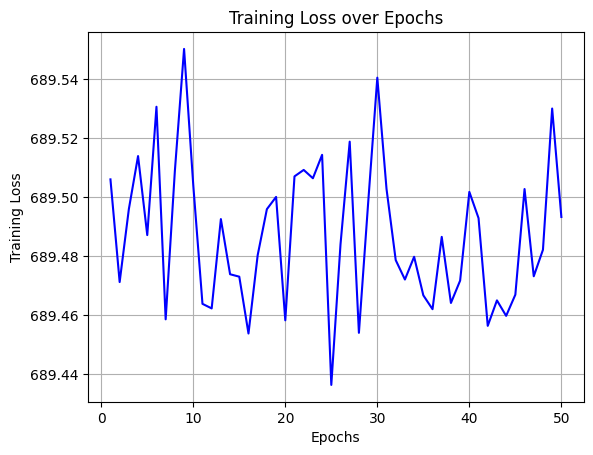

In [82]:
import matplotlib.pyplot as plt

# Create x-axis values (epochs)
epochs = range(1, len(train_losses) + 1)

# Plot the training loss
plt.plot(epochs, train_losses, 'b-')
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.title('Training Loss over Epochs')
plt.grid(True)
plt.show()

In [70]:
from cnn_utils import test_prediction_to_csv

test_prediction_to_csv(predictions, "predicting_cnn.csv", test_data)